In [1]:
from subprocess import Popen, PIPE
from pathlib import Path
import time
import shutil
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

In [24]:
SERVER_TYPES = ['blocking', 'nonblocking', 'async']
EXPERIMENT_VARIABLES = [('request_size', 11), ('n_clients', 8), ('request_delay_ms', 6), ('n_requests_per_client', 6)]
COLUMNS_X = [column for column, _ in EXPERIMENT_VARIABLES]
COLUMNS_Y = ['processing_ms', 'response_ms', 'client_ms']
PLOT_COLUMNS = COLUMNS_X + COLUMNS_Y #[f'{server_type}_{column}' for server_type in SERVER_TYPES for column in COLUMNS_Y]

In [35]:
experiment_descs = pd.read_csv('results/different_computers/client.csv', index_col='experiment_id')
plottable_data = {server_type: {column: pd.DataFrame(columns=PLOT_COLUMNS) for column in COLUMNS_X} for server_type in SERVER_TYPES}
experiment_id = 0
for server_type in SERVER_TYPES:
    request_offset = 0
    server_data = pd.read_csv(f'results/different_computers/{server_type}.csv')
    for column, n_experiments in EXPERIMENT_VARIABLES:
        for i in range(n_experiments):
            n_clients = experiment_descs.loc[experiment_id, 'n_clients']
            n_requests_per_client = experiment_descs.loc[experiment_id, 'n_requests_per_client']
            n_requests = n_clients * n_requests_per_client

            experiment_server_data = server_data.loc[request_offset : request_offset + n_requests - 1, :]
            experiment_client_data = pd.read_csv(f'results/different_computers/{experiment_id:04}/clients.csv')

            df = plottable_data[server_type][column]
            df_id = len(df)
            df.loc[df_id, COLUMNS_X] = experiment_descs.loc[experiment_id]
            df.loc[df_id, 'processing_ms' ] = 1e-6 * experiment_server_data.loc[:, 'processing_ns' ].median()
            df.loc[df_id, 'response_ms'   ] = 1e-6 * experiment_server_data.loc[:, 'response_ns'   ].median()
            df.loc[df_id, 'client_ms'     ] = 1e-6 * experiment_client_data.loc[:, 'total_ns'      ].median() / n_requests_per_client

            request_offset += n_requests
            experiment_id += 1

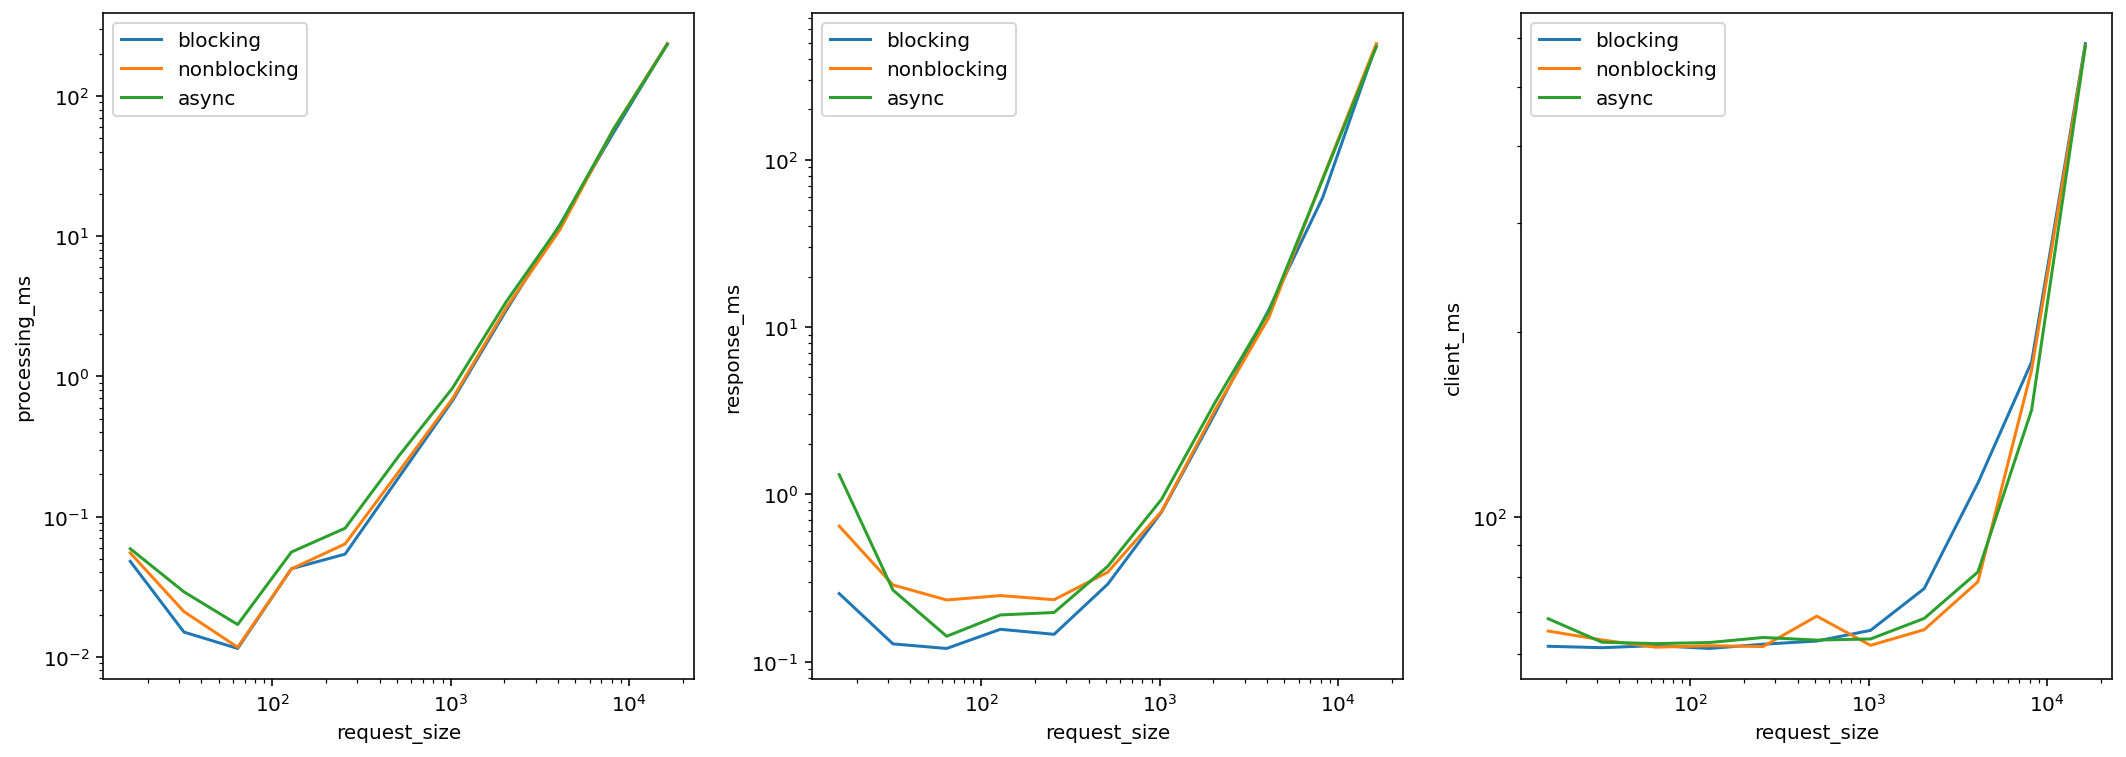

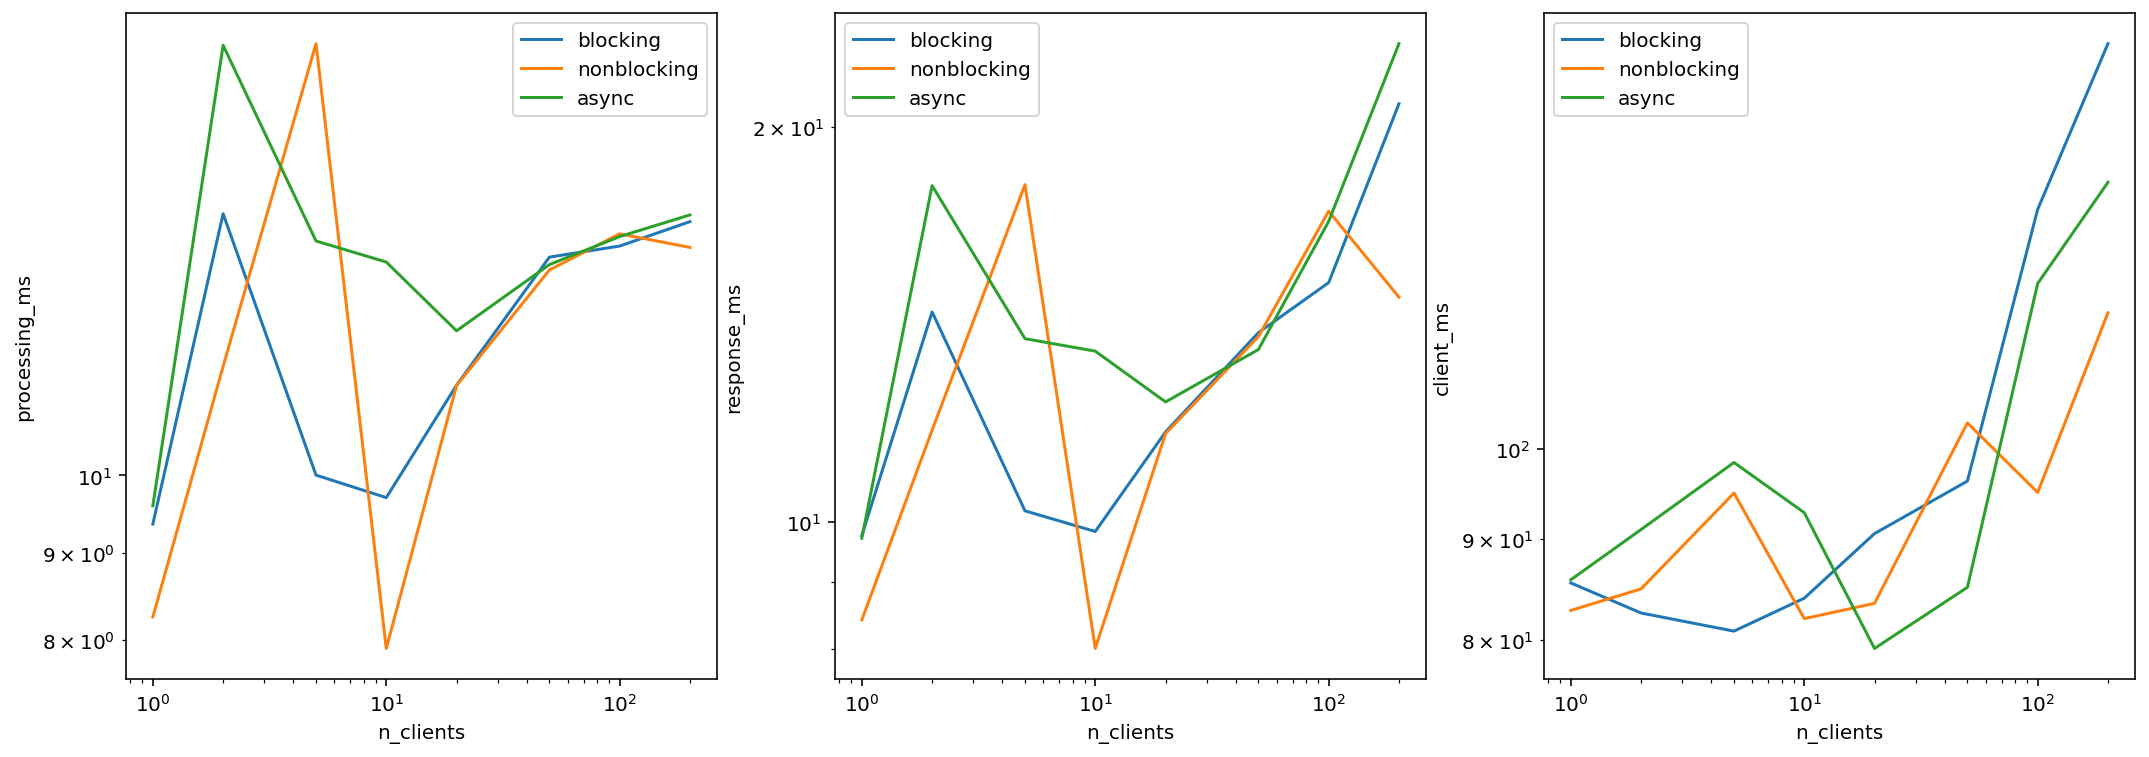

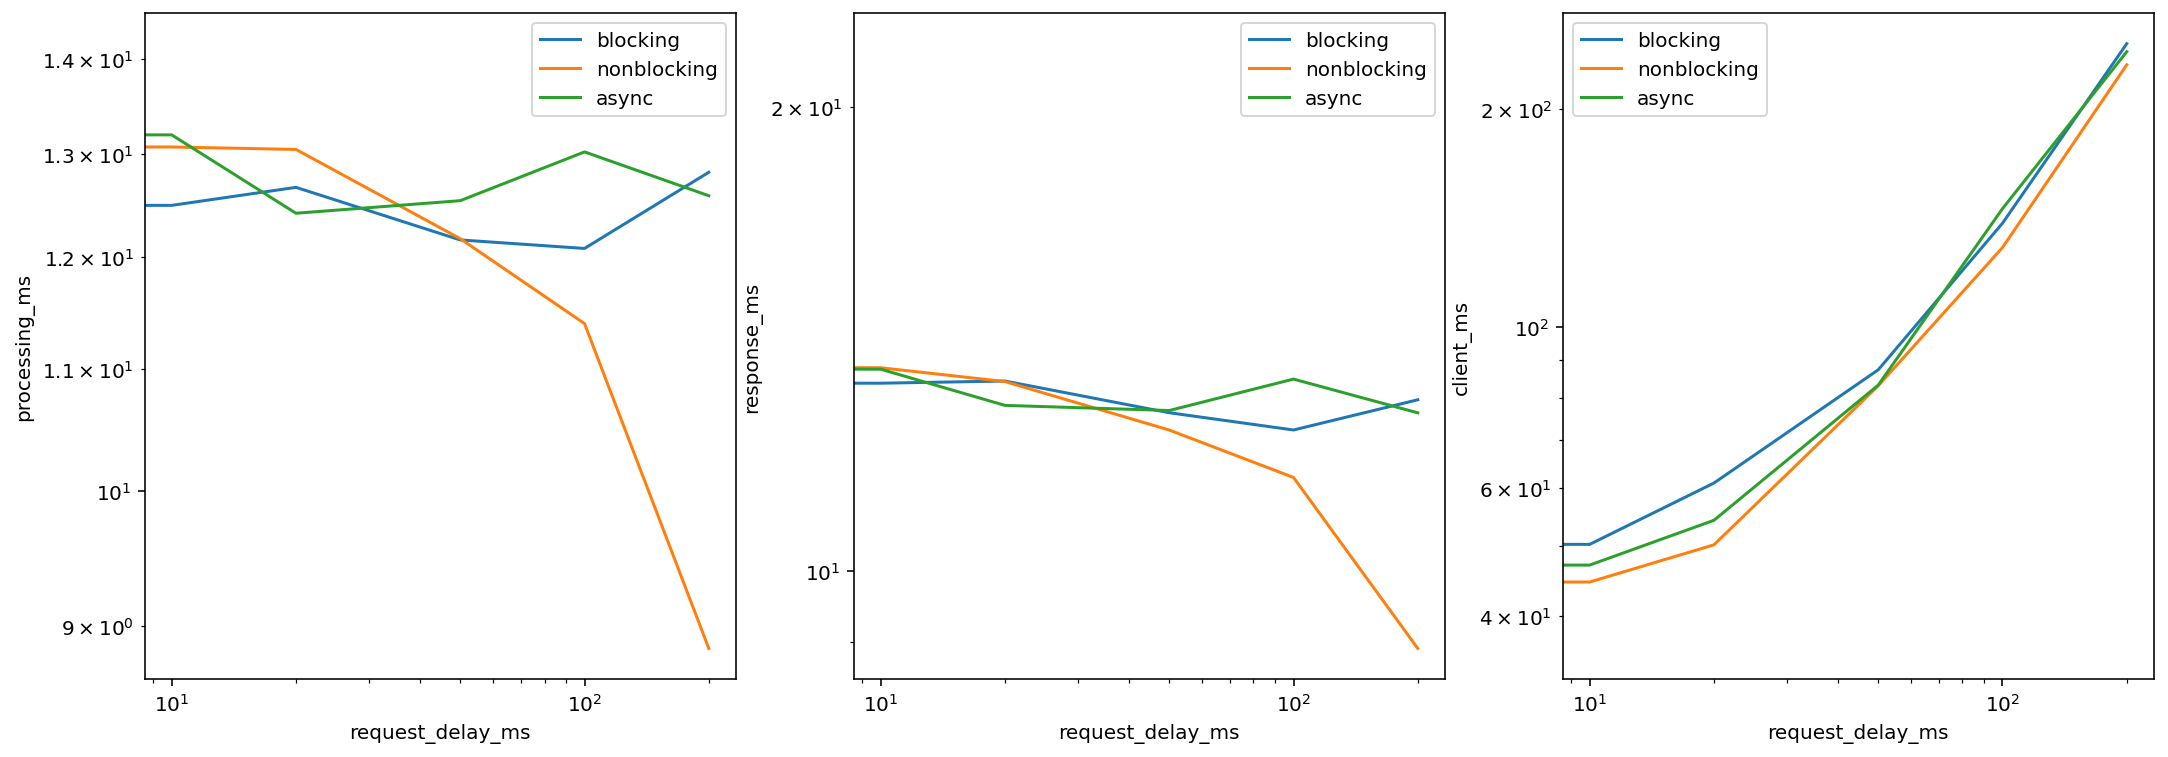

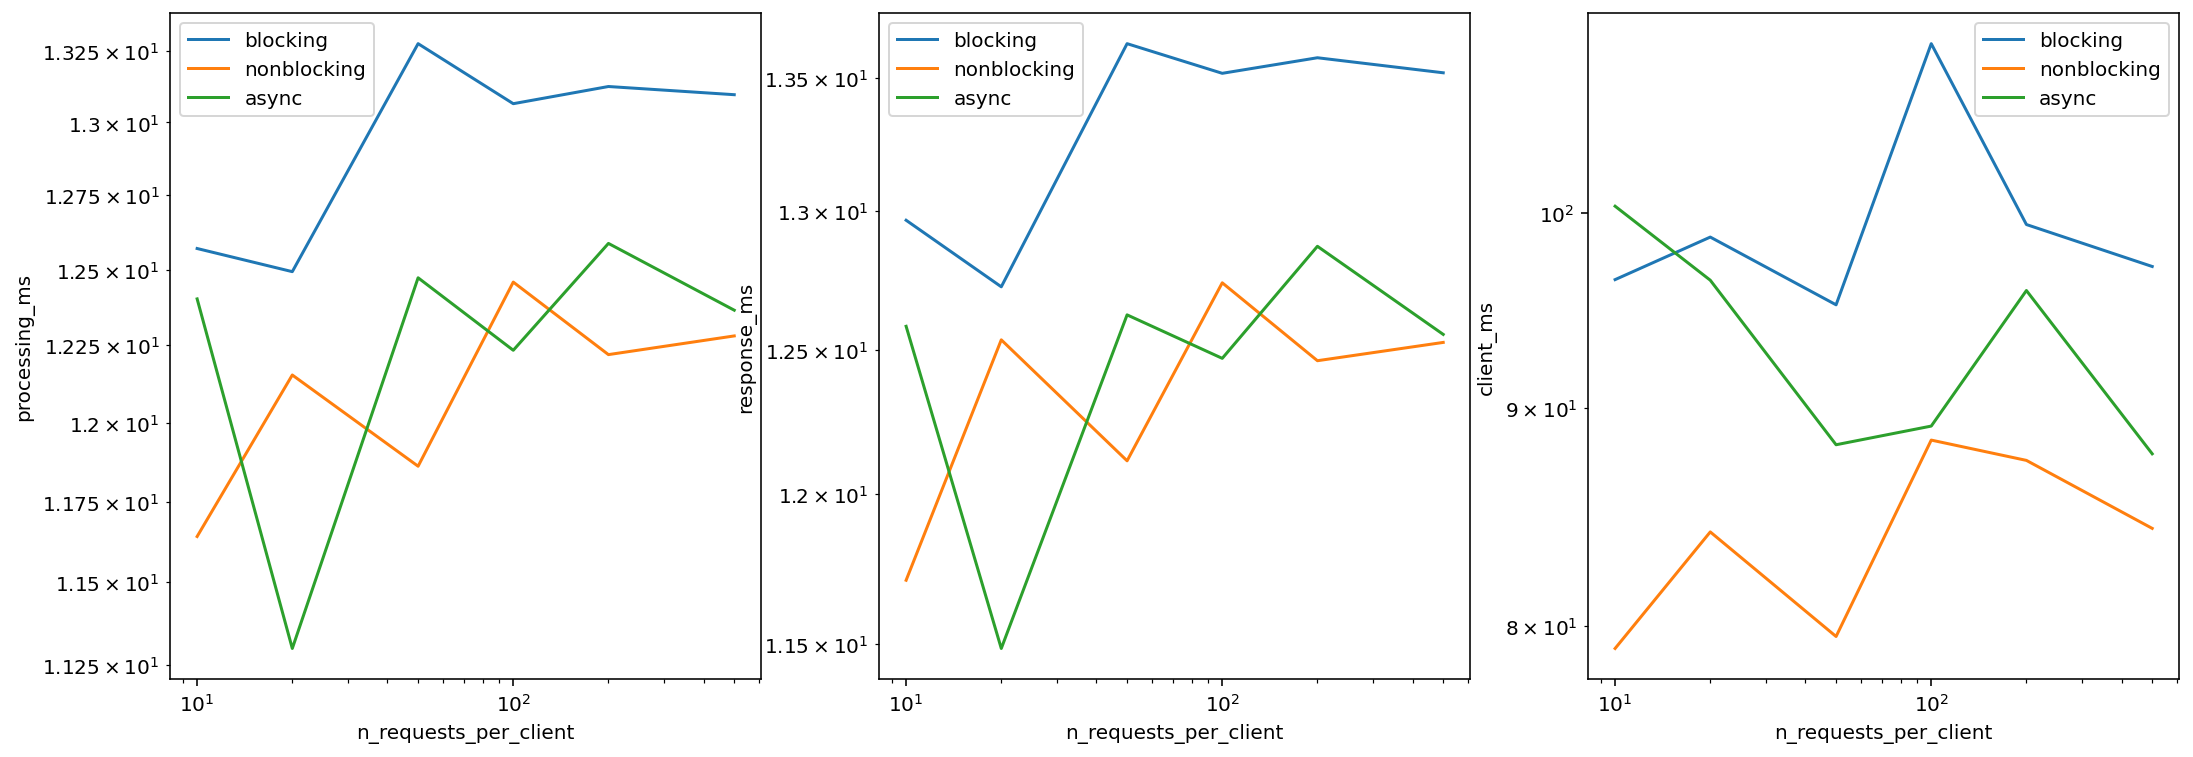

In [37]:
for column in COLUMNS_X:
    fig, axes = plt.subplots(1, len(COLUMNS_Y), dpi=144, figsize=(18, 6))
    for ax in axes:
        ax.set_xscale('log')
        ax.set_yscale('log')

    for i, what in enumerate(COLUMNS_Y):
        for server_type in SERVER_TYPES:
            df = plottable_data[server_type][column]
            df.plot(x=column, y=what, label=server_type, ylabel=what, ax=axes[i])